In [1]:
#@title Load the imports

# from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

Ran the import statements.


In [2]:
train_df = pd.read_csv("california_housing_train.csv")
test_df = pd.read_csv("california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

Normalize values
When creating a model with multiple features, the values of each feature should cover roughly the same range. For example, if one feature's range spans 500 to 100,000 and another feature's range spans 2 to 12, then the model will be difficult or impossible to train. Therefore, you should normalize features in a multi-feature model.

The following code cell normalizes datasets by converting each raw value (including the label) to its Z-score. A Z-score is the number of standard deviations from the mean for a particular raw value. For example, consider a feature having the following characteristics:

The mean is 60.
The standard deviation is 10.
The raw value 75 would have a Z-score of +1.5:

  Z-score = (75 - 60) / 10 = +1.5
The raw value 38 would have a Z-score of -2.2:

  Z-score = (38 - 60) / 10 = -2.2

In [9]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean() #mean 
train_df_std = train_df.std() #Standard Deviaton

#calculating the Normal / Z-score
train_df_norm = (train_df-train_df_mean)/train_df_std

# Examine some of the values of the normalized training set. Notice that most 
# Z-scores fall between -2 and +2.

train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
992,1.2,-1.4,-0.4,-0.4,-0.5,-0.1,-0.5,-0.1,-0.6
14463,-1.3,0.8,1.1,0.2,-0.2,-0.3,-0.2,2.8,2.5
15707,-1.4,1.0,1.3,0.1,0.1,0.4,0.1,-0.1,-0.1
1516,1.2,-0.8,-2.0,3.4,2.2,3.5,2.3,0.6,-0.5
12939,-1.1,1.1,-1.1,-0.1,-0.4,-0.1,-0.3,0.4,-0.6


In [10]:
# Calculate the Z-scores of each column in the test set and
# write those Z-scores into a new pandas DataFrame named test_df_norm.
test_df_mean = test_df.mean()
test_df_std = test_df.std()

#calculating the Z-score
test_df_norm = (test_df-test_df_mean)/test_df_std

Task 1: Create a binary label
In classification problems, the label for every example must be either 0 or 1. Unfortunately, the natural label in the California Housing Dataset, median_house_value, contains floating-point values like 80,100 or 85,700 rather than 0s and 1s, while the normalized version of median_house_values contains floating-point values primarily between -3 and +3.

Your task is to create a new column named median_house_value_is_high in both the training set and the test set . If the median_house_value is higher than a certain arbitrary value (defined by threshold), then set median_house_value_is_high to 1. Otherwise, set median_house_value_is_high to 0.

Hint: The cells in the median_house_value_is_high column must each hold 1 and 0, not True and False. To convert True and False to 1 and 0, call the pandas DataFrame function astype(float).

In [11]:
threshold = 265000 # This is the 75th percentile for median house values.
train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float)
train_df_norm["median_house_value_is_high"].head(8000)

# Print out a few example cells from the beginning and 
# middle of the training set, just to make sure that
# your code created only 0s and 1s in the newly created
# median_house_value_is_high column
train_df_norm["median_house_value_is_high"].head(8000)

992     0.0
14463   1.0
15707   0.0
1516    0.0
12939   0.0
         ..
5087    0.0
647     1.0
4489    0.0
10624   0.0
3232    0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

Represent features in feature columns
This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in feature_layer) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model.

In [14]:
feature_columns = []
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)
total_rooms = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(total_rooms)

feature_layer = layers.DenseFeatures(feature_columns)

Define functions that build and train a model
The following code cell defines two functions:

create_model(my_learning_rate, feature_layer, my_metrics), which defines the model's topography.
train_model(model, dataset, epochs, label_name, batch_size, shuffle), uses input features and labels to train the model.

In [45]:
def create_model(my_learning_rate, feature_layer, my_metrics):
    #Create and compile a simple classification model.
      # Most simple tf.keras models are sequential.
    model = tf.keras.Sequential()
    
    # Add the feature layer (the list of features and how they are represented)
    # to the model.
    
    model.add(feature_layer)
    
    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units = 1,activation = tf.sigmoid))
    
    # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(my_learning_rate),loss=tf.keras.losses.BinaryCrossentropy(), metrics=my_metrics)
    
    return model

def train_model(model, dataset, epochs, my_label, batch_size = None, shuffle = True):
    """Feed a dataset into the model in order to train it."""

      # The x parameter of tf.keras.Model.fit can be a list of arrays, where
      # each array contains the data for one feature.  Here, we're passing
      # every column in the dataset. Note that the feature_layer will filter
      # away most of those columns, leaving only the desired columns and their
      # representations as features.
    features = {name: np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(my_label))
    
    model_fit = model.fit(x = features, y = label, batch_size=batch_size, epochs= epochs, shuffle = shuffle)
    
    # The list of epochs is stored separately from the rest of history.
    epochs = model_fit.epoch
    
    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(model_fit.history)
    return epochs,  hist


Define a plotting function
The following matplotlib function plots one or more curves, showing how various classification metrics change with each epoch.

In [47]:
def plot_curve(epochs, hist, list_of_metrices):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Values")
    
    for i in list_of_metrices:
        x = hist[i]
        plt.plot(epochs[1:], x[1:], label = i)
    
    plt.legend()

Invoke the creating, training, and plotting functions
The following code cell calls specify the hyperparameters, and then invokes the functions to create and train the model, and then to plot the results.

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 1ms/step - loss: 0.6666 - accuracy: 0.2498
Epoch 2/20
170/170 [==============================] - 0s 1ms/step - loss: 0.5978 - accuracy: 0.2498
Epoch 3/20
170/170 [==============================] - 0s 1ms/step - loss: 0.5419 - accuracy: 0.2498
Epoch 4/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4979 - accuracy: 0.2498
Epoch 5/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4648 - accuracy: 0.2498
Epoch 6/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4404 - accuracy: 0.2498
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4237 - accuracy: 0.2501
Epoch 8/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4128 - accuracy: 0.2528
Epoch 9/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4062 - accurac

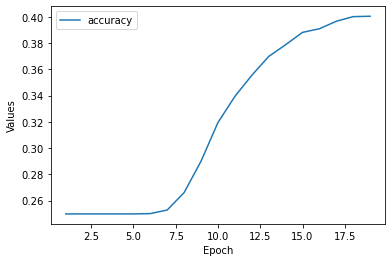

In [48]:
#The following variables are hypermeters
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.05
my_label = "median_house_value_is_high"

# Establish the metrics the model will measure.
my_metrices = [tf.keras.metrics.BinaryAccuracy(name = "accuracy", threshold=classification_threshold)]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, my_metrices)

#Train the model on training set
epoch, hist = train_model(my_model, train_df_norm, epochs, my_label, batch_size)

list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epoch, hist, list_of_metrics_to_plot)

Evaluate the model against the test set
At the end of model training, you ended up with a certain accuracy against the training set. Invoke the following code cell to determine your model's accuracy against the test set.

In [50]:
features = {name: np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(my_label))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 1ms/step - loss: 0.4069 - accuracy: 0.3920


[0.4068511128425598, 0.3919999897480011]

In [51]:
# A perfect model would make 100% accurate predictions.
# Our model makes 80% accurate predictions. 80% sounds
# good, but note that a model that always guesses 
# "median_house_value_is_high is False" would be 75% 
# accurate. 

Task 3: Add precision and recall as metrics
Relying solely on accuracy, particularly for a class-imbalanced data set (like ours), can be a poor way to judge a classification model. Modify the code in the following code cell to enable the model to measure not only accuracy but also precision and recall. We have added accuracy and precision; your task is to add recall. See the TensorFlow Reference for details.

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 2ms/step - loss: 0.9056 - accuracy: 0.2415 - precision: 0.2434 - recall: 0.9654
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.8108 - accuracy: 0.2451 - precision: 0.2462 - recall: 0.9805
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.7277 - accuracy: 0.2483 - precision: 0.2486 - recall: 0.9934
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6567 - accuracy: 0.2498 - precision: 0.2498 - recall: 1.0000
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5979 - accuracy: 0.2498 - precision: 0.2498 - recall: 1.0000
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5504 - accuracy: 0.2498 - precision: 0.2498 - recall: 1.0000
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - 

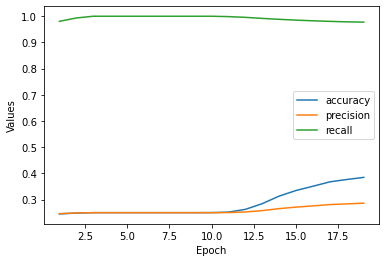

In [59]:
#The following variables are hypermeters
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.05
my_label = "median_house_value_is_high"
# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall:

my_metrices = [tf.keras.metrics.BinaryAccuracy(name = "accuracy", threshold = classification_threshold), tf.keras.metrics.Precision(name = "precision", thresholds = classification_threshold), tf.keras.metrics.Recall(name = "recall", thresholds = classification_threshold)]

my_model = create_model(learning_rate, feature_layer, my_metrices)

#train model
epochs, hist = train_model(my_model,train_df_norm,epochs, my_label, batch_size = batch_size)
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

Task 4: Experiment with the classification threshold (if time permits)
Experiment with different values for classification_threshold in the code cell within "Invoke the creating, training, and plotting functions." What value of classification_threshold produces the highest accuracy?

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 2ms/step - loss: 0.5966 - accuracy: 0.7687 - precision: 0.5315 - recall: 0.6263
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5403 - accuracy: 0.8019 - precision: 0.6081 - recall: 0.5821
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4962 - accuracy: 0.8186 - precision: 0.6658 - recall: 0.5503
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4627 - accuracy: 0.8266 - precision: 0.7070 - recall: 0.5227
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4383 - accuracy: 0.8306 - precision: 0.7344 - recall: 0.5046
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4209 - accuracy: 0.8324 - precision: 0.7526 - recall: 0.4900
Epoch 7/20
170/170 [==============================] - 0s 1ms/step - 

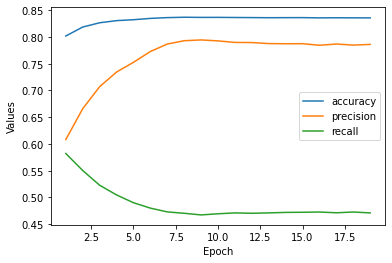

In [60]:
#@title Double-click to view the solution for Task 4.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.52
label_name = "median_house_value_is_high"

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

# A `classification_threshold` of slightly over 0.5
# appears to produce the highest accuracy (about 83%).
# Raising the `classification_threshold` to 0.9 drops 
# accuracy by about 5%.  Lowering the 
# `classification_threshold` to 0.3 drops accuracy by 
# about 3%. 

Task 5: Summarize model performance (if time permits)
If time permits, add one more metric that attempts to summarize the model's overall performance.

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 2ms/step - loss: 0.5999 - auc: 0.8301
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5424 - auc: 0.8329
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4981 - auc: 0.8345
Epoch 4/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4642 - auc: 0.8353
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4395 - auc: 0.8353
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4219 - auc: 0.8362
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4106 - auc: 0.8366
Epoch 8/20
170/170 [==============================] - 0s 1ms/step - loss: 0.4038 - auc: 0.8366
Epoch 9/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4003 - auc: 0.8366
Epoch 10/20
170/170 [==============

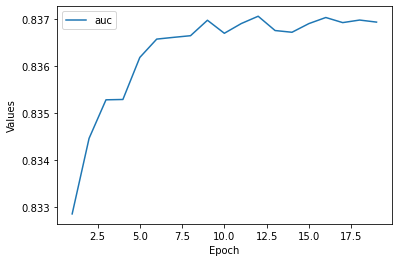

In [61]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

# AUC is a reasonable "summary" metric for 
# classification models.
# Here is the updated definition of METRICS to 
# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)